# Stable Diffusion

**Goal**: Using Stable diffusion to create images from text descriptions. Starts by working with each of the components of Stable Diffusion individually. Finishes by using Stable Diffusion pipeline that joins all of the components together, providing a much more convenient interface.

**Objectives**

- Use the CLIP model to create text embeddings.
- Decode latent vectors into an image with a VAE.
- Apply a denoising diffusion model to randomly-generated noise.
- Use a scheduler to perform denoising over multiple steps.
- Generate images matching a text description with a Stable Diffusion pipeline.

In [41]:
import sys

import diffusers
import matplotlib.pyplot as plt 
import torch
import transformers
from IPython.display import display
from PIL import Image
from torchinfo import summary
from tqdm.notebook import tqdm

In [42]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("diffusers version:", diffusers.__version__)
print("transformers version:", transformers.__version__)
print("torch version:", torch.__version__)
print("PIL version:", Image.__version__)

Platform: win32
Python version: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
---
diffusers version: 0.33.1
transformers version: 4.51.3
torch version: 2.2.2+cpu
PIL version: 10.2.0


In [43]:
if torch.cuda.is_available():
    device = "cuda"
    dtype = torch.float16
else:
    device = "cpu"
    dtype = torch.float32

print(f"Using {device} device with {dtype} data type.")

Using cpu device with torch.float32 data type.


**Creating Text Embeddings**

Stable Diffusion attempts to produce an image aligned to a text description. We start by working on that text description, by converting human-readable text into an embedding. This means that the text will be represented by a bunch of numbers, which the model will be able to ingest. 

Stable Diffusion uses text embeddings from the Constrastive Language-Image Pre-Training (CLIP) model. We need two pieces from this model; first is the tokenizer that splits up a string into tokens, a word, part of a word, or single character.

In [44]:
tokenizer = transformers.CLIPTokenizer.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="tokenizer",
    torch_dtype=dtype
)
print(tokenizer)

CLIPTokenizer(name_or_path='CompVis/stable-diffusion-v1-4', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)


In [45]:
type(tokenizer)

transformers.models.clip.tokenization_clip.CLIPTokenizer

Example usage:

In [46]:
text = "Hello, world!"
result = tokenizer(text)

print(type(result))
print(result)

<class 'transformers.tokenization_utils_base.BatchEncoding'>
{'input_ids': [49406, 3306, 267, 1002, 256, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [47]:
result["input_ids"]

[49406, 3306, 267, 1002, 256, 49407]

In [48]:
result.input_ids

[49406, 3306, 267, 1002, 256, 49407]

Decode Tokens:

In [49]:
for token in result.input_ids:
    print(tokenizer.decode(token))

<|startoftext|>
hello
,
world
!
<|endoftext|>


**Image generation prompt**

In [50]:
prompt = "A red bird flies through a blue sky over a green tree."

Tokenization:

In [51]:
text_tokens = tokenizer(
    prompt,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)

print(text_tokens.input_ids)
print(text_tokens.input_ids.shape)

tensor([[49406,   320,   736,  3329,  8070,  1417,   320,  1746,  2390,   962,
           320,  1901,  2677,   269, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])
torch.Size([1, 77])


Tokens for the empty string input:

In [52]:
uncond_tokens = tokenizer(
    "",
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

print(uncond_tokens.input_ids)
print(uncond_tokens.input_ids.shape)

tensor([[49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])
torch.Size([1, 77])


These tokens will be converted into a text embedding with the text_encoder component.

In [53]:
embedder = transformers.CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder",
    torch_dtype=dtype
)
embedder.to(device)  

# Print out a summary of this neural network
summary(embedder)

Layer (type:depth-idx)                                       Param #
CLIPTextModel                                                --
├─CLIPTextTransformer: 1-1                                   --
│    └─CLIPTextEmbeddings: 2-1                               --
│    │    └─Embedding: 3-1                                   37,945,344
│    │    └─Embedding: 3-2                                   59,136
│    └─CLIPEncoder: 2-2                                      --
│    │    └─ModuleList: 3-3                                  85,054,464
│    └─LayerNorm: 2-3                                        1,536
Total params: 123,060,480
Trainable params: 123,060,480
Non-trainable params: 0

We call it with the token IDs to generate the embedding.

In [54]:
with torch.no_grad():  # No need for gradient calculations
    text_embedding = embedder(text_tokens.input_ids.to(device))

print(type(text_embedding))
print(text_embedding.keys())

<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
odict_keys(['last_hidden_state', 'pooler_output'])


The  class and shape of the last_hidden_state attribute.

In [55]:
print("Class:", type(text_embedding.last_hidden_state))
print("Shape:",text_embedding.last_hidden_state.shape )

Class: <class 'torch.Tensor'>
Shape: torch.Size([1, 77, 768])


We call it with the token IDs to generate the embedding.

In [56]:
with torch.no_grad():
    uncond_embedding = embedder(uncond_tokens.input_ids.to(device))

print(uncond_embedding.last_hidden_state.shape)

torch.Size([1, 77, 768])


Concatenate the unconditioned embedding followed by the text embedding into a tensor called all_embeddings

In [57]:
all_embeddings = torch.cat(
    [
        uncond_embedding.last_hidden_state,
        text_embedding.last_hidden_state,
    ]
)

print(all_embeddings.shape)

torch.Size([2, 77, 768])


**Generating Random Latent Vectors**

Stable Diffusion uses a Variational Auto-Encoder (VAE) to generate images from latent vectors.

In [58]:
vae = diffusers.AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="vae",
    torch_dtype=dtype
)
vae.to(device)  # Run it on the GPU

summary(vae)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Layer (type:depth-idx)                             Param #
AutoencoderKL                                      --
├─Encoder: 1-1                                     --
│    └─Conv2d: 2-1                                 3,584
│    └─ModuleList: 2-2                             --
│    │    └─DownEncoderBlock2D: 3-1                738,944
│    │    └─DownEncoderBlock2D: 3-2                2,690,304
│    │    └─DownEncoderBlock2D: 3-3                10,754,560
│    │    └─DownEncoderBlock2D: 3-4                9,443,328
│    └─UNetMidBlock2D: 2-3                         --
│    │    └─ModuleList: 3-5                        1,051,648
│    │    └─ModuleList: 3-6                        9,443,328
│    └─GroupNorm: 2-4                              1,024
│    └─SiLU: 2-5                                   --
│    └─Conv2d: 2-6                                 36,872
├─Decoder: 1-2                                     --
│    └─Conv2d: 2-7                                 18,944
│    └─ModuleList: 2-8

This VAE is constructed mainly of convolutional layers, and it's able to produce outputs of various sizes

In [59]:
height = 512
width = 512

The encoder will downscale both the width and height by a factor of 8. The decoder will upscale by the same factor.

In [60]:
scale_factor = 8

The number of channels in the latent vector is stored in the configuration:

In [61]:
n_channels = vae.config.latent_channels
print(n_channels)

4


Latent vectors will be a 4-D tensor, representing (batch, channel, height, width). Don't be confused by the fact that there happen to be four channels. That is a complete coincidence.

In [62]:
latent_shape = (
    1, # Batch size
    n_channels, # Latent channels
    height // scale_factor, # Height
    width // scale_factor, # Width
)

random_latents = torch.randn(latent_shape, device=device, dtype=dtype)

print(random_latents.shape)

torch.Size([1, 4, 64, 64])


Since there are four channels, we can't visualize the latent vectors as an RGB imag

In [63]:
def plot_latents(latents):
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(latents[0, i].cpu().numpy())
        plt.colorbar()

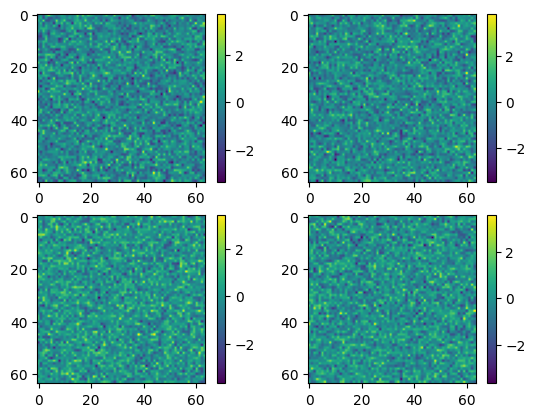

In [64]:
# Plot the latent vector
plot_latents(random_latents)

The following cell will use the VAE's decoder to convert the latent vectors into an image.

In [65]:
latents = random_latents
# Decode the latents
with torch.no_grad():
    scaling_factor = torch.tensor(vae.config.scaling_factor, device=device, dtype=dtype)
    decoded = vae.decode(latents / scaling_factor).sample

In [66]:
print("Shape:", decoded.shape)

Shape: torch.Size([1, 3, 512, 512])


This is in (batch, channels, height, width) format. However, PIL expects images in (height, width, channels) format. We can use the .permute() method to switch things around. We'll also convert the tensor into a NumPy array.

In [67]:
# Permute the dimensions and convert to NumPy
unscaled = decoded.permute(0, 2, 3, 1).cpu().numpy()
print("Shape:", unscaled.shape)

Shape: (1, 512, 512, 3)


 Plot a histogram of the values in this array to help us understand the distribution of these values.

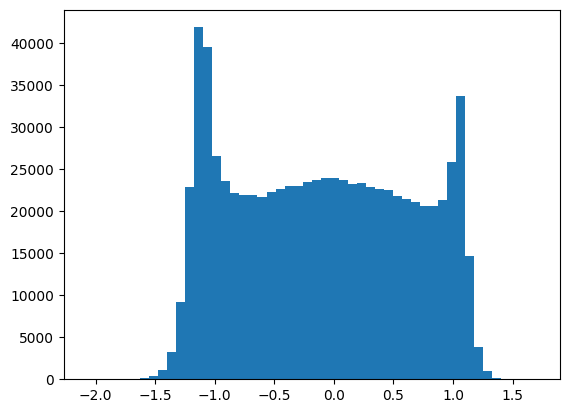

In [68]:
plt.hist(
    unscaled.flatten(),
    bins=50,
);

This shows us that most of the values are in the range [-1, 1]. We'll scale this to the range [0, 255]. Values that start outside of this range will be clipped to the min or max. We'll also convert the datatype to the unsigned 8-bit integer type commonly used for images.

In [69]:
# Scale the image values to be between 0 and 255
scaled = ((unscaled + 1) * 255 / 2).clip(0, 255).round().astype("uint8")

Creating and displaying a PIL image:

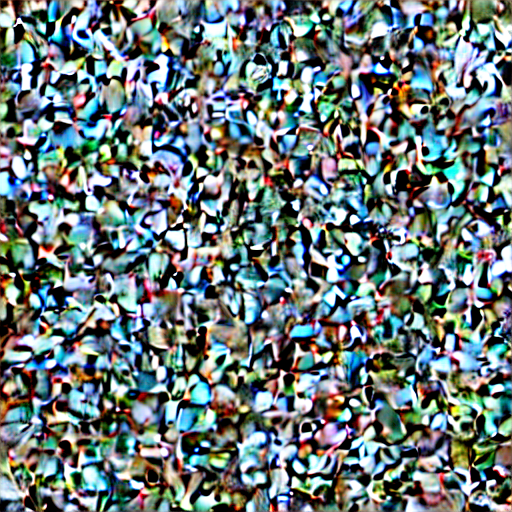

In [70]:
# Create a PIL image
Image.fromarray(scaled[0])

This does not look like anything in particular, because we started with a random latent vector. But it also does not look like noise, because the latent space encodes common patterns. We're seeing a random superposition of these common patterns.

**Latent to image function** - a function that returns the image corresponding to a latent vector.

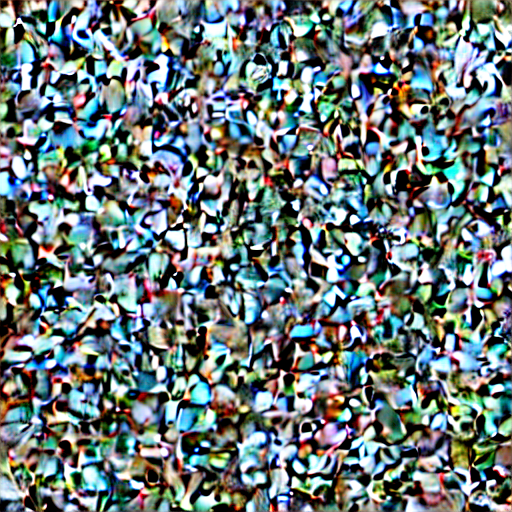

In [71]:
def latents_to_image(latents, vae=vae):
    """Transform the latent vector to a image, using a VAE decoder.

    Inputs:  latents  Latent vector(s) as a 4-D PyTorch tensor.  Only
                      the first element of the batch will be used.
             vae      The VAE used to decode the image from latents.

    Outputs: A PIL image corresponding to the latents.
    """
    # Decode the latents
    with torch.no_grad():
        decoded = vae.decode(latents / vae.config.scaling_factor).sample
    # Permute the dimensions and convert to NumPy
    unscaled = decoded.permute(0, 2, 3, 1).cpu().numpy()
    # Scale the image values to be between 0 and 255
    scaled = ((unscaled + 1) * 255 / 2).clip(0, 255).round().astype("uint8")
    # Return a PIL image
    return Image.fromarray(scaled[0])

latents_to_image(random_latents)

**Denoising Diffusion**

Next task is to perform denoising diffusion on our latent vector.

We need a model to predict the noise in our latent vector. For that, we use a U-Net model. These are similar to the ResNet models commonly used for image analysis. This particular model is a condition model. This mean that it can take our text embedding as input, to judge how well the denoised image matches the text.

In [72]:
unet = diffusers.UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet",
    torch_dtype=torch.float16
)
unet.to(device)

summary(unet)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Layer (type:depth-idx)                                            Param #
UNet2DConditionModel                                              --
├─Conv2d: 1-1                                                     11,840
├─Timesteps: 1-2                                                  --
├─TimestepEmbedding: 1-3                                          --
│    └─Linear: 2-1                                                410,880
│    └─SiLU: 2-2                                                  --
│    └─Linear: 2-3                                                1,639,680
├─ModuleList: 1-4                                                 --
│    └─CrossAttnDownBlock2D: 2-4                                  --
│    │    └─ModuleList: 3-1                                       5,092,480
│    │    └─ModuleList: 3-2                                       4,510,080
│    │    └─ModuleList: 3-3                                       921,920
│    └─CrossAttnDownBlock2D: 2-5                               

The scheduler will govern this process.

In [73]:
scheduler = diffusers.UniPCMultistepScheduler.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="scheduler"
)

print(scheduler)

UniPCMultistepScheduler {
  "_class_name": "UniPCMultistepScheduler",
  "_diffusers_version": "0.33.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "disable_corrector": [],
  "dynamic_thresholding_ratio": 0.995,
  "final_sigmas_type": "zero",
  "flow_shift": 1.0,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "predict_x0": true,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "solver_order": 2,
  "solver_p": null,
  "solver_type": "bh2",
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_flow_sigmas": false,
  "use_karras_sigmas": false
}



Creating a starting latent vector by multiplying random_latents by the scheduler's init_noise_sigma.

In [74]:
latents = random_latents * scheduler.init_noise_sigma

latents.shape

torch.Size([1, 4, 64, 64])

Demonstration with a single denoising step:

In [75]:
scheduler.set_timesteps(1)
print("Steps:", scheduler.timesteps)

Steps: tensor([999])


In [76]:
t = scheduler.timesteps[0]

print(t)

tensor(999)


Latent inputs tensors with copies of latents.

In [77]:
# Assemble the latent inputs
latent_inputs = torch.cat([latents, latents])

print(latent_inputs.shape)

torch.Size([2, 4, 64, 64])


Predicted noise

In [ ]:
# Predict the noise
scaled_inputs = scheduler.scale_model_input(latent_inputs, timestep=t)
with torch.no_grad():
    noise = unet(scaled_inputs, t, encoder_hidden_states=all_embeddings)

# Split the unconditioned and conditioned predictions
noise_uncond, noise_cond = noise.sample.chunk(2)

We combine these two estimates together

In [ ]:
guidance_scale = 7.5  # A pretty middle-of-the-road value
noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)

print(noise_pred.shape)

In [ ]:
# Plot the noise prediction with `plot_latents`
plot_latents(noise_pred)

In [ ]:
# Update the variable `latents` based on the predicted noise
latents = scheduler.step(noise_pred, t, latents).prev_sample

In [ ]:
# Plot the latent vector with `plot_latents`
plot_latents(latents)

In [ ]:
# Decode the latent vector to an image
latents_to_image(latents)

Denoising Loop

In [ ]:
num_steps = 50  # A typical number.  Increase for cleaner results.
scheduler.set_timesteps(num_steps)

# We'll start with the same random latent values as before.
latents = random_latents * scheduler.init_noise_sigma

# This will let us update the image through the training.
display_handle = display(latents_to_image(latents, vae), display_id="latent_display")

with torch.no_grad():
    for t in tqdm(scheduler.timesteps):
        # Assemble the latent inputs
        latent_inputs = torch.cat([latents, latents])
        # Predict the noise
        scaled_inputs = scheduler.scale_model_input(latent_inputs, timestep=t)
        with torch.no_grad():
            noise = unet(scaled_inputs, t, encoder_hidden_states=all_embeddings)
        # Split the unconditioned and conditioned predictions
        noise_uncond, noise_cond = noise.sample.chunk(2)
        # Combine the predictions according to the guidance scale
        noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)
        # Update the variable `latents` based on the predicted noise
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        # This will update the image based on the current latent vector.
        display_handle.update(latents_to_image(latents, vae))